<a href="https://colab.research.google.com/github/Dango233/PrincessGenerator/blob/main/Latent_Princess_Generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Latent Princess Generator v1.1 (Deprecated)
This model is deprecated. Please check to [Majesty Diffusion](https://github.com/multimodalart/MajestyDiffusion)
CLIP Guided Latent Diffusion model
by [dango233](https://github.com/Dango233/) (did the smart stuff) and [@multimodalart](https://twitter.com/multimodalart)

The LAION-400M trained model and part of inference code are from [CompVis Latent Diffusion](https://github.com/CompVis/latent-diffusion) . The guided-diffusion method is modified by Dango233 based on [Katherine Crowson](https://twitter.com/RiversHaveWings)'s guided diffusion notebook. Some functions and methods are from various code masters (nsheppard, DanielRussRuss and others).


## Save model and outputs on Google Drive? 

In [ ]:
#@markdown Enable saving outputs to Google Drive to save your creations at AI/models
save_outputs_to_google_drive = True #@param {type:"boolean"}
#@markdown Enable saving models to Google Drive to avoid downloading the model every Colab instance
save_models_to_google_drive = True #@param {type:"boolean"}

if save_outputs_to_google_drive or save_models_to_google_drive:
    from google.colab import drive
    try:
      drive.mount('/content/gdrive')
    except:
      save_outputs_to_google_drive = False
      save_models_to_google_drive = False

model_path = "/content/gdrive/MyDrive/AI/models" if save_models_to_google_drive else "/content/"
outputs_path = "/content/gdrive/MyDrive/AI/Latent_Princess" if save_outputs_to_google_drive else "/content/outputs"
!mkdir -p $model_path
!mkdir -p $outputs_path
print(f"Model will be stored at {model_path}")
print(f"Outputs will be saved to {outputs_path}")

#If you want to run it locally change it to true
is_local = False
skip_installs = False
if(is_local):
  model_path = "/choose/your/local/model/path"
  outputs_path = "/choose/your/local/outputs/path"
  skip_installs = True

# Setup stuff

In [7]:
#@title Installation
if(not skip_installs):
    import sys
    sys.path.append(".")
    !git clone https://github.com/multimodalart/latent-diffusion
    !git clone https://github.com/CompVis/taming-transformers
    !git clone https://github.com/TencentARC/GFPGAN
    !pip install -e ./taming-transformers
    !pip install omegaconf>=2.0.0 pytorch-lightning>=1.0.8 torch-fidelity einops
    !pip install transformers
    !pip install dotmap
    !pip install resize-right
    !pip install piq
    !pip install lpips
    !pip install basicsr
    !pip install facexlib
    !pip install realesrgan

    sys.path.append('./taming-transformers')
    from taming.models import vqgan
    from subprocess import Popen, PIPE
    try:
        import mmc
    except:
        # install mmc
        !git clone https://github.com/apolinario/Multi-Modal-Comparators --branch mock_api_plus
        !pip install poetry
        !cd Multi-Modal-Comparators; poetry build
        !cd Multi-Modal-Comparators; pip install dist/mmc*.whl
        
        # optional final step:
        #poe napm_installs
        !python Multi-Modal-Comparators/src/mmc/napm_installs/__init__.py
    # suppress mmc warmup outputs
    import mmc.loaders

Now, download the checkpoint (~5.7 GB). This will usually take 3-6 minutes.

In [8]:
#@title Download models
import os
if os.path.isfile(f"{model_path}/latent_diffusion_txt2img_f8_large.ckpt"):
    print("Using Latent Diffusion model saved from Google Drive")
else:    
    !wget -O $model_path/latent_diffusion_txt2img_f8_large.ckpt https://ommer-lab.com/files/latent-diffusion/nitro/txt2img-f8-large/model.ckpt

if os.path.isfile(f"{model_path}/ava_vit_l_14_336_linear.pth"):
  print("Using ViT-L/14@336px aesthetic model from Google Drive")
else:
  !wget -O $model_path/ava_vit_l_14_336_linear.pth https://multimodal.art/models/ava_vit_l_14_336_linear.pth

if os.path.isfile(f"{model_path}/ava_vit_l_14_linear.pth"):
  print("Using ViT-L/14 aesthetic model from Google Drive")
else:
  !wget -O $model_path/ava_vit_l_14_linear.pth https://multimodal.art/models/ava_vit_l_14_linear.pth

if os.path.isfile(f"{model_path}/ava_vit_b_16_linear.pth"):
  print("Using ViT-B/16 aesthetic model from Google Drive")
else:
  !wget -O $model_path/ava_vit_b_16_linear.pth http://batbot.tv/ai/models/v-diffusion/ava_vit_b_16_linear.pth
if os.path.isfile(f"{model_path}/openimages_512x_png_embed224.npz"):
  print("Using openimages png from Google Drive")
else:
  !wget -O $model_path/openimages_512x_png_embed224.npz https://github.com/nshepperd/jax-guided-diffusion/raw/8437b4d390fcc6b57b89cedcbaf1629993c09d03/data/openimages_512x_png_embed224.npz
if os.path.isfile(f"{model_path}/imagenet_512x_jpg_embed224.npz"):
  print("Using imagenet antijpeg from Google Drive")
else:
  !wget -O $model_path/imagenet_512x_jpg_embed224.npz https://github.com/nshepperd/jax-guided-diffusion/raw/8437b4d390fcc6b57b89cedcbaf1629993c09d03/data/imagenet_512x_jpg_embed224.npz
if os.path.isfile(f"{model_path}/GFPGANv1.3.pth"):
  print("Using GFPGAN v1.3 from Google Drive")
else:
  !wget -O $model_path/GFPGANv1.3.pth https://github.com/TencentARC/GFPGAN/releases/download/v1.3.0/GFPGANv1.3.pth
!cp $model_path/GFPGANv1.3.pth GFPGAN/experiments/pretrained_models/GFPGANv1.3.pth


Let's also check what type of GPU we've got.

In [9]:
!nvidia-smi

In [10]:
#@title Import stuff
import argparse, os, sys, glob
import torch
import numpy as np
from omegaconf import OmegaConf
from PIL import Image
from tqdm.auto import tqdm, trange
tqdm_auto_model = __import__("tqdm.auto", fromlist=[None]) 
sys.modules['tqdm'] = tqdm_auto_model
from einops import rearrange
from torchvision.utils import make_grid
import transformers
import gc
sys.path.append('./latent-diffusion')
from ldm.util import instantiate_from_config
from ldm.models.diffusion.ddim import DDIMSampler
from ldm.models.diffusion.plms import PLMSSampler
import tensorflow as tf
from dotmap import DotMap
import ipywidgets as widgets
from math import pi

from subprocess import Popen, PIPE

from dataclasses import dataclass
from functools import partial
import gc
import io
import math
import sys
import random
from piq import brisque
from itertools import product
from IPython import display
import lpips
from PIL import Image, ImageOps
import requests
import torch
from torch import nn
from torch.nn import functional as F
from torchvision import models
from torchvision import transforms
from torchvision import transforms as T
from torchvision.transforms import functional as TF
from numpy import nan
from threading import Thread
import time

#sys.path.append('../CLIP')
#Resizeright for better gradient when resizing
#sys.path.append('../ResizeRight/')
#sys.path.append('../cloob-training/')

from resize_right import resize

import clip
#from cloob_training import model_pt, pretrained

#pretrained.list_configs()
from torch.utils.tensorboard import SummaryWriter


In [11]:
#@title Load necessary functions
torch.backends.cudnn.benchmark = True
def load_model_from_config(config, ckpt, verbose=False):
    print(f"Loading model from {ckpt}")
    sd = torch.load(ckpt, map_location="cuda")["state_dict"]
 #   sd = pl_sd["state_dict"]
    model = instantiate_from_config(config.model)
    m, u = model.load_state_dict(sd, strict = False)
    if len(m) > 0 and verbose:
        print("missing keys:")
        print(m)
    if len(u) > 0 and verbose:
        print("unexpected keys:")
        print(u)

    model.requires_grad_(False).half().eval().to('cuda')
    return model


config = OmegaConf.load("./latent-diffusion/configs/latent-diffusion/txt2img-1p4B-eval.yaml")  # TODO: Optionally download from same location as ckpt and chnage this logic
model = load_model_from_config(config, f"{model_path}/latent_diffusion_txt2img_f8_large.ckpt")  # TODO: check path

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model = model.half().eval().to(device)

def parse_prompt(prompt):
    if prompt.startswith('http://') or prompt.startswith('https://') or prompt.startswith("E:") or prompt.startswith("C:") or prompt.startswith("D:"):
        vals = prompt.rsplit(':', 2)
        vals = [vals[0] + ':' + vals[1], *vals[2:]]
    else:
        vals = prompt.rsplit(':', 1)
    vals = vals + ['', '1'][len(vals):]
    return vals[0], float(vals[1])


class MakeCutouts(nn.Module):
    def __init__(self, cut_size,
                 Overview=4, 
                 WholeCrop = 0, WC_Allowance = 10, WC_Grey_P=0.2,
                 InnerCrop = 0, IC_Size_Pow=0.5, IC_Grey_P = 0.2
                 ):
        super().__init__()
        self.cut_size = cut_size
        self.Overview = Overview
        self.WholeCrop= WholeCrop
        self.WC_Allowance = WC_Allowance
        self.WC_Grey_P = WC_Grey_P
        self.InnerCrop = InnerCrop
        self.IC_Size_Pow = IC_Size_Pow
        self.IC_Grey_P = IC_Grey_P
        self.augs = T.Compose([
            #T.RandomHorizontalFlip(p=0.5),
            T.Lambda(lambda x: x + torch.randn_like(x) * 0.01),
            T.RandomAffine(degrees=0, 
                           translate=(0.05, 0.05), 
                           #scale=(0.9,0.95),
                           fill=-1,  interpolation = T.InterpolationMode.BILINEAR, ),
            T.Lambda(lambda x: x + torch.randn_like(x) * 0.01),
            #T.RandomPerspective(p=1, interpolation = T.InterpolationMode.BILINEAR, fill=-1,distortion_scale=0.2),
            T.Lambda(lambda x: x + torch.randn_like(x) * 0.01),
            T.RandomGrayscale(p=0.1),
            T.Lambda(lambda x: x + torch.randn_like(x) * 0.01),
            T.ColorJitter(brightness=0.05, contrast=0.05, saturation=0.05),
        ])

    def forward(self, input):
        gray = transforms.Grayscale(3)
        sideY, sideX = input.shape[2:4]
        max_size = min(sideX, sideY)
        min_size = min(sideX, sideY, self.cut_size)
        l_size = max(sideX, sideY)
        output_shape = [input.shape[0],3,self.cut_size,self.cut_size] 
        output_shape_2 = [input.shape[0],3,self.cut_size+2,self.cut_size+2]
        pad_input = F.pad(input,((sideY-max_size)//2+round(max_size*0.055),(sideY-max_size)//2+round(max_size*0.055),(sideX-max_size)//2+round(max_size*0.055),(sideX-max_size)//2+round(max_size*0.055)), **padargs)
        cutouts_list = []
        
        if self.Overview>0:
            cutouts = []
            cutout = resize(pad_input, out_shape=output_shape, antialiasing=True)
            output_shape_all = list(output_shape)
            output_shape_all[0]=self.Overview*input.shape[0]
            pad_input = pad_input.repeat(input.shape[0],1,1,1)
            cutout = resize(pad_input, out_shape=output_shape_all)
            if aug: cutout=self.augs(cutout)
            cutouts_list.append(cutout)
            
        if self.InnerCrop >0:
            cutouts=[]
            for i in range(self.InnerCrop):
                size = int(torch.rand([])**self.IC_Size_Pow * (max_size - min_size) + min_size)
                offsetx = torch.randint(0, sideX - size + 1, ())
                offsety = torch.randint(0, sideY - size + 1, ())
                cutout = input[:, :, offsety:offsety + size, offsetx:offsetx + size]
                if i <= int(self.IC_Grey_P * self.InnerCrop):
                    cutout = gray(cutout)
                cutout = resize(cutout, out_shape=output_shape)
                cutouts.append(cutout)
            if cutout_debug:
                TF.to_pil_image(cutouts[-1].add(1).div(2).clamp(0, 1).squeeze(0)).save("content/diff/cutouts/cutout_InnerCrop.jpg",quality=99)
            cutouts_tensor = torch.cat(cutouts)
            cutouts=[]
            cutouts_list.append(cutouts_tensor)
        cutouts=torch.cat(cutouts_list)
        return cutouts


def spherical_dist_loss(x, y):
    x = F.normalize(x, dim=-1)
    y = F.normalize(y, dim=-1)
    return (x - y).norm(dim=-1).div(2).arcsin().pow(2).mul(2)


def tv_loss(input):
    """L2 total variation loss, as in Mahendran et al."""
    input = F.pad(input, (0, 1, 0, 1), 'replicate')
    x_diff = input[..., :-1, 1:] - input[..., :-1, :-1]
    y_diff = input[..., 1:, :-1] - input[..., :-1, :-1]
    return (x_diff**2 + y_diff**2).mean([1, 2, 3])


def range_loss(input, range_min, range_max):
    return (input - input.clamp(range_min,range_max)).pow(2).mean([1, 2, 3])

def symmetric_loss(x):
    w = x.shape[3]
    diff = (x - torch.flip(x,[3])).square().mean().sqrt()/(x.shape[2]*x.shape[3]/1e4)
    return(diff)

def fetch(url_or_path):
    """Fetches a file from an HTTP or HTTPS url, or opens the local file."""
    if str(url_or_path).startswith('http://') or str(url_or_path).startswith('https://'):
        r = requests.get(url_or_path)
        r.raise_for_status()
        fd = io.BytesIO()
        fd.write(r.content)
        fd.seek(0)
        return fd
    return open(url_or_path, 'rb')


def to_pil_image(x):
    """Converts from a tensor to a PIL image."""
    if x.ndim == 4:
        assert x.shape[0] == 1
        x = x[0]
    if x.shape[0] == 1:
        x = x[0]
    return TF.to_pil_image((x.clamp(-1, 1) + 1) / 2)


normalize = transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
                                 std=[0.26862954, 0.26130258, 0.27577711])

def centralized_grad(x, use_gc=True, gc_conv_only=False):
    if use_gc:
        if gc_conv_only:
            if len(list(x.size())) > 3:
                x.add_(-x.mean(dim=tuple(range(1, len(list(x.size())))), keepdim=True))
        else:
            if len(list(x.size())) > 1:
                x.add_(-x.mean(dim=tuple(range(1, len(list(x.size())))), keepdim=True))
    return x

def cond_fn(x, t):
    t=1000-t
    t=t[0]
    with torch.enable_grad():
        global test, clamp_start_, clamp_max
        x = x.detach().requires_grad_()
        x_in = model.decode_first_stage(x)
        test = x
        display_handler(x_in,t,1,False)
        n = x_in.shape[0]
        clip_guidance_scale = clip_guidance_index[t]
        make_cutouts = {}
        x_in_grad = torch.zeros_like(x_in)
        for i in clip_list:
            make_cutouts[i] = MakeCutouts(clip_size[i],
             Overview= cut_overview[t], 
             InnerCrop = cut_innercut[t], 
                                          IC_Size_Pow=cut_ic_pow, IC_Grey_P = cut_icgray_p[t]
             )
            cutn = cut_overview[t]+cut_innercut[t]

        for j in range(cutn_batches):
            losses=0
            for i in clip_list:
                clip_in = clip_normalize[i](make_cutouts[i](x_in.add(1).div(2)).to("cuda"))
                image_embeds = clip_model[i].encode_image(clip_in).float().unsqueeze(0).expand([target_embeds[i].shape[0],-1,-1])
                target_embeds_temp = target_embeds[i].unsqueeze(1).expand([-1,cutn*n,-1])
                dists = spherical_dist_loss(image_embeds, target_embeds_temp)
                dists = dists.mean(1).mul(weights[i].squeeze()).mean()
                losses+=dists*clip_guidance_scale * (2 if i == "ViT-L/14@336px" else (.4 if "cloob" in i else 1))
                if i == "ViT-L/14@336px" and aes_scale !=0:
                    aes_loss = (aesthetic_model_336(F.normalize(image_embeds, dim=-1))).mean() 
                    losses -= aes_loss * aes_scale 
                if i == "ViT-L/14" and aes_scale !=0:
                    aes_loss = (aesthetic_model_224(F.normalize(image_embeds, dim=-1))).mean() 
                    losses -= aes_loss * aes_scale 
                if i == "ViT-B/16" and aes_scale !=0:
                    aes_loss = (aesthetic_model_16(F.normalize(image_embeds, dim=-1))).mean() 
                    losses -= aes_loss * aes_scale 
            x_in_grad += torch.autograd.grad(losses, x_in)[0] / cutn_batches / len(clip_list)
                #losses += dists
                #losses = losses / len(clip_list)                
                #gc.collect()
 
        tv_losses = tv_loss(x).sum() * tv_scales[0] +\
            tv_loss(F.interpolate(x, scale_factor= 1/2)).sum()* tv_scales[1] + \
            tv_loss(F.interpolate(x, scale_factor = 1/4)).sum()* tv_scales[2] + \
            tv_loss(F.interpolate(x, scale_factor = 1/8)).sum()* tv_scales[3] 
        range_scale= range_index[t]
        range_losses = range_loss(x_in,RGB_min,RGB_max).sum() * range_scale
        loss =  tv_losses  + range_losses
        if symmetric_loss_scale != 0: loss +=  symmetric_loss(x_in) * symmetric_loss_scale
        if init_image is not None and init_scale:
            lpips_loss = (lpips_model(x_in, init) * init_scale).squeeze().mean()
            loss += lpips_loss
        loss_grad = torch.autograd.grad(loss, x_in, )[0]
        x_in_grad += loss_grad
        grad = -torch.autograd.grad(x_in, x, x_in_grad)[0]
        grad = torch.nan_to_num(grad, nan=0.0, posinf=0, neginf=0)
        if grad_center: grad = centralized_grad(grad, use_gc=True, gc_conv_only=False)
        mag = grad.square().mean().sqrt()
        if mag==0 or torch.isnan(mag):
            print("ERROR")
            print(t)
            return(grad)
        if t>=0:
            if active_function == "softsign":
                grad = F.softsign(grad*grad_scale/mag)
            if active_function == "tanh":
                grad = (grad/mag*grad_scale).tanh()
            if active_function=="clamp":
                grad = grad.clamp(-mag*grad_scale*2,mag*grad_scale*2)
        if grad.abs().max()>0:
            grad=grad/grad.abs().max()*opt.mag_mul
            magnitude = grad.square().mean().sqrt()
        else:
            return(grad)
        clamp_max = clamp_index[t]
        #print(magnitude, end = "\r")
        grad = grad* magnitude.clamp(max= clamp_max) /magnitude#0.2
        grad = grad.detach()
    return grad

def null_fn(x_in):
    return(torch.zeros_like(x_in))

def display_handler(x,i,cadance = 5, decode = True):
    global progress, image_grid, writer, img_tensor, im
    img_tensor = x
    if i%cadance==0:
        if decode: 
            x = model.decode_first_stage(x)
        grid = make_grid(torch.clamp((x+1.0)/2.0, min=0.0, max=1.0),round(x.shape[0]**0.5))
        grid = 255. * rearrange(grid, 'c h w -> h w c').detach().cpu().numpy()
        image_grid = grid.copy(order = "C") 
        with io.BytesIO() as output:
            im = Image.fromarray(grid.astype(np.uint8))
            im.save(output, format = "PNG")
            progress.value = output.getvalue()
            if generate_video:
                im.save(p.stdin, 'PNG')


            
def cond_clamp(image,t): 
    #if t >=0:
        #mag=image.square().mean().sqrt()
        tb.add_histogram("cond_clamp", image)
        #mag = (mag*cc).clamp(1.6,100)
        image = image.clamp(-cc, cc)
        image = torch.nan_to_num(image, nan=0.0, posinf=cc, neginf=-cc)
        return(image)

def make_schedule(t_start, t_end, step_size=1):
    schedule = []
    par_schedule = []
    t = t_start
    while t > t_end:
        schedule.append(t)
        t -= step_size
    schedule.append(t_end)
    return np.array(schedule)

lpips_model = lpips.LPIPS(net='vgg').to(device)

#Alstro's aesthetic model
aesthetic_model_336 = torch.nn.Linear(768,1).cuda()
aesthetic_model_336.load_state_dict(torch.load(f"{model_path}/ava_vit_l_14_336_linear.pth"))

aesthetic_model_224 = torch.nn.Linear(768,1).cuda()
aesthetic_model_224.load_state_dict(torch.load(f"{model_path}/ava_vit_l_14_linear.pth"))

aesthetic_model_16 = torch.nn.Linear(512,1).cuda()
aesthetic_model_16.load_state_dict(torch.load(f"{model_path}/ava_vit_b_16_linear.pth"))

def do_run():
  #  with torch.cuda.amp.autocast():
        global progress,target_embeds, weights, zero_embed, init, clamp_index
        make_cutouts = {}
        for i in clip_list:
             make_cutouts[i] = MakeCutouts(clip_size[i],Overview=1)
        target_embeds, weights ,zero_embed = {}, {}, {}
        for i in clip_list:
            target_embeds[i] = []
            weights[i]=[]

        for prompt in prompts:
            txt, weight = parse_prompt(prompt)
            for i in clip_list:
                if "cloob" not in i:
                    with torch.cuda.amp.autocast():
                        embeds = clip_model[i].encode_text(clip_tokenize[i](txt).to(device))
                        target_embeds[i].append(embeds)
                        weights[i].append(weight)
                else:
                        embeds = clip_model[i].encode_text(clip_tokenize[i](txt).to(device))
                        target_embeds[i].append(embeds)
                        weights[i].append(weight)

        for prompt in image_prompts:
            print(f"processing{prompt}",end="\r")
            path, weight = parse_prompt(prompt)
            img = Image.open(fetch(path)).convert('RGB')
            img = TF.resize(img, min(opt.W, opt.H, *img.size), transforms.InterpolationMode.LANCZOS)
            for i in clip_list:
                if "cloob" not in i:
                    with torch.cuda.amp.autocast():
                        batch = make_cutouts[i](TF.to_tensor(img).unsqueeze(0).to(device))
                        embed = clip_model[i].encode_image(clip_normalize[i](batch))
                        target_embeds[i].append(embed)
                        weights[i].extend([weight])
                else:
                        batch = make_cutouts[i](TF.to_tensor(img).unsqueeze(0).to(device))
                        embed = clip_model[i].encode_image(clip_normalize[i](batch))
                        target_embeds[i].append(embed)
                        weights[i].extend([weight])
        if anti_jpg != 0:
            target_embeds["ViT-B/32"].append(torch.tensor([np.load(f"{model_path}/openimages_512x_png_embed224.npz")['arr_0']-np.load(f"{model_path}/imagenet_512x_jpg_embed224.npz")['arr_0']], device = device))
            weights["ViT-B/32"].append(anti_jpg)

        for i in clip_list:
            target_embeds[i] = torch.cat(target_embeds[i])
            weights[i] = torch.tensor([weights[i]], device=device)
        shape = [4, opt.H//8, opt.W//8]
        init = None
        mask = None
        transform = T.GaussianBlur(kernel_size=3, sigma=0.4)
        if init_image is not None:
            init = Image.open(fetch(init_image)).convert('RGB')
            init = TF.to_tensor(init).to(device).unsqueeze(0)
            if init_rotate: init = torch.rot90(init, 1, [3,2]) 
            init = resize(init,out_shape = [opt.n_samples,3,opt.H, opt.W])
            init = init.mul(2).sub(1).half()
            init_encoded =  model.first_stage_model.encode(init).sample()* init_magnitude + init_brightness
            init_encoded =  init_encoded.mul(1-init_noise) + torch.randn([opt.n_samples,*shape], device=device).mul(init_noise)
        else:
            init = None
            init_encoded = None
        if init_mask is not None:
            mask = Image.open(fetch(init_mask)).convert('RGB')
            mask = TF.to_tensor(mask).to(device).unsqueeze(0)
            if mask_rotate: mask = torch.rot90(init, 1, [3,2]) 
            mask = resize(mask,out_shape = [opt.n_samples,1,opt.H//8, opt.W//8])
            mask = transform(mask)
            print(mask)


        progress = widgets.Image(layout = widgets.Layout(max_width = "400px",max_height = "512px"))
        display.display(progress)

        if opt.plms:
            sampler = PLMSSampler(model)
        else:
            sampler = DDIMSampler(model)

        os.makedirs(opt.outdir, exist_ok=True)
        outpath = opt.outdir

        prompt = opt.prompt
        sample_path = os.path.join(outpath, "samples")
        os.makedirs(sample_path, exist_ok=True)
        base_count = len(os.listdir(sample_path))

        all_samples=list()
        with torch.enable_grad():
            with torch.cuda.amp.autocast():
                with model.ema_scope():
                    uc = None
                    if opt.scale != 1.0:
                        uc = model.get_learned_conditioning(opt.n_samples * opt.uc).cuda()
                    for n in trange(opt.n_iter, desc="Sampling"):
                        c = model.get_learned_conditioning(opt.n_samples * prompt).cuda()
                        if init_encoded is None:
                            x_T = torch.randn([opt.n_samples,*shape], device=device)
                        else:
                            x_T = init_encoded
                        for custom_schedule in custom_schedules:
                            if type(custom_schedule) != type(""):
                                samples_ddim, _ = sampler.sample(S=opt.ddim_steps,
                                                                 conditioning=c,
                                                                 batch_size=opt.n_samples,
                                                                 shape=shape,
                                                                 custom_schedule = custom_schedule,
                                                                 verbose=False,
                                                                 unconditional_guidance_scale=opt.scale,
                                                                 unconditional_conditioning=uc,
                                                                 eta=opt.ddim_eta,
                                                                 eta_end = opt.eta_end,
                                                                 img_callback=None if use_cond_fn else display_handler,
                                                                 cond_fn=cond_fn, #if use_cond_fn else None,
                                                                 temperature = opt.temperature,
                                                                 x_adjust_fn=cond_clamp,
                                                                 x_T = x_T,
                                                                 x0=x_T,
                                                                 mask=mask
                                                                )
                                x_T = samples_ddim.clamp(-1.6,1.6)
                            else:
                                torch.cuda.empty_cache()
                                gc.collect()
                                method, scale_factor = custom_schedule.split(":")
                                scale_factor = float(scale_factor)
                                clamp_index = np.array(clamp_index) * scale_factor
                                if method == "latent":
                                    x_T = resize(samples_ddim, scale_factors=scale_factor, antialiasing=True)*scale_div
                                if method == "gfpgan":
                                    temp_file_name = "temp_"+f"{str(round(time.time()))}.png"
                                    temp_file = os.path.join(sample_path, temp_file_name)
                                    im.save(temp_file, format = "PNG")
                                    GFP_factor = 2 if scale_factor > 1 else 1
                                    GFP_ver = 1.3 #if GFP_factor == 1 else 1.2
                                    %cd GFPGAN
                                    !python inference_gfpgan.py -i $temp_file -o results -v $GFP_ver -s $GFP_factor
                                    %cd ..
                                    init = Image.open(fetch(f"GFPGAN/results/restored_imgs/{temp_file_name}")).convert('RGB')
                                    init = TF.to_tensor(init).to(device).unsqueeze(0)
                                    opt.H, opt.W = opt.H*scale_factor, opt.W*scale_factor
                                    init = resize(init,out_shape = [opt.n_samples,3,opt.H, opt.W], antialiasing=True)
                                    init = init.mul(2).sub(1).half()
                                    x_T =  (model.first_stage_model.encode(init).sample()*init_magnitude)
                                    x_T += (torch.rand_like(x_T)-0.5)*init_noise
                                    x_T = x_T.clamp(-3,3)
                                    
                        x_samples_ddim = model.decode_first_stage(samples_ddim)
                        x_samples_ddim = torch.clamp((x_samples_ddim+1.0)/2.0, min=0.0, max=1.0)


                        for x_sample in x_samples_ddim:
                            x_sample = 255. * rearrange(x_sample.cpu().numpy(), 'c h w -> h w c')
                            Image.fromarray(x_sample.astype(np.uint8)).save(os.path.join(sample_path, f"{base_count:04}.png"))
                            base_count += 1
                        all_samples.append(x_samples_ddim)



        # additionally, save as grid
        grid = torch.stack(all_samples, 0)
        grid = rearrange(grid, 'n b c h w -> (n b) c h w')
        grid = make_grid(grid, nrow=opt.n_samples)

        # to image
        grid = 255. * rearrange(grid, 'c h w -> h w c').cpu().numpy()
        Image.fromarray(grid.astype(np.uint8)).save(os.path.join(outpath, f'{str(round(time.time()))}.png'))

        Image.fromarray(image_grid.astype(np.uint8)).save(os.path.join(outpath, f'grid_{str(round(time.time()))}.png'), format = "PNG")



# Run!

#### Perceptors (Choose your CLIP and CLIP-like models) 
Be careful if you don't pay for Colab Pro selecting more CLIPs might make you go out of memory. If you do have Pro, try adding ViT-L14 to your mix

In [13]:
#@title Choose your perceptor models

# suppress mmc warmup outputs
import mmc.loaders
clip_load_list = []
#@markdown #### Open AI CLIP models
ViT_B32 = False #@param {type:"boolean"}
ViT_B16 = True #@param {type:"boolean"}
ViT_L14 = False #@param {type:"boolean"}
ViT_L14_336px = False #@param {type:"boolean"}
#RN101 = False #@param {type:"boolean"}
#RN50 = False #@param {type:"boolean"}
RN50x4 = False #@param {type:"boolean"}
RN50x16 = False #@param {type:"boolean"}
RN50x64 = False #@param {type:"boolean"}

#@markdown #### OpenCLIP models
ViT_B16_plus = True #@param {type: "boolean"}

#@markdown #### Multilangual CLIP models 
clip_farsi = False #@param {type: "boolean"}
clip_korean = False #@param {type: "boolean"}

#@markdown #### CLOOB models
cloob_ViT_B16 = False #@param {type: "boolean"}

# @markdown Load even more CLIP models (from [Multi-Modal-Comparators](https://github.com/dmarx/Multi-Modal-Comparators))
model1 = "" # @param ["[clip - openai - RN50]","[clip - openai - RN101]","[clip - mlfoundations - RN50--yfcc15m]","[clip - mlfoundations - RN50--cc12m]","[clip - mlfoundations - RN50-quickgelu--yfcc15m]","[clip - mlfoundations - RN50-quickgelu--cc12m]","[clip - mlfoundations - RN101--yfcc15m]","[clip - mlfoundations - RN101-quickgelu--yfcc15m]","[clip - mlfoundations - ViT-B-32--laion400m_e31]","[clip - mlfoundations - ViT-B-32--laion400m_e32]","[clip - mlfoundations - ViT-B-32--laion400m_avg]","[clip - mlfoundations - ViT-B-32-quickgelu--laion400m_e31]","[clip - mlfoundations - ViT-B-32-quickgelu--laion400m_e32]","[clip - mlfoundations - ViT-B-32-quickgelu--laion400m_avg]","[clip - mlfoundations - ViT-B-16--laion400m_e31]","[clip - mlfoundations - ViT-B-16--laion400m_e32]","[clip - sbert - ViT-B-32-multilingual-v1]","[clip - facebookresearch - clip_small_25ep]","[simclr - facebookresearch - simclr_small_25ep]","[slip - facebookresearch - slip_small_25ep]","[slip - facebookresearch - slip_small_50ep]","[slip - facebookresearch - slip_small_100ep]","[clip - facebookresearch - clip_base_25ep]","[simclr - facebookresearch - simclr_base_25ep]","[slip - facebookresearch - slip_base_25ep]","[slip - facebookresearch - slip_base_50ep]","[slip - facebookresearch - slip_base_100ep]","[clip - facebookresearch - clip_large_25ep]","[simclr - facebookresearch - simclr_large_25ep]","[slip - facebookresearch - slip_large_25ep]","[slip - facebookresearch - slip_large_50ep]","[slip - facebookresearch - slip_large_100ep]","[clip - facebookresearch - clip_base_cc3m_40ep]","[slip - facebookresearch - slip_base_cc3m_40ep]","[slip - facebookresearch - slip_base_cc12m_35ep]","[clip - facebookresearch - clip_base_cc12m_35ep]"] {allow-input: true}
model2 = "" # @param ["[clip - openai - RN50]","[clip - openai - RN101]","[clip - mlfoundations - RN50--yfcc15m]","[clip - mlfoundations - RN50--cc12m]","[clip - mlfoundations - RN50-quickgelu--yfcc15m]","[clip - mlfoundations - RN50-quickgelu--cc12m]","[clip - mlfoundations - RN101--yfcc15m]","[clip - mlfoundations - RN101-quickgelu--yfcc15m]","[clip - mlfoundations - ViT-B-32--laion400m_e31]","[clip - mlfoundations - ViT-B-32--laion400m_e32]","[clip - mlfoundations - ViT-B-32--laion400m_avg]","[clip - mlfoundations - ViT-B-32-quickgelu--laion400m_e31]","[clip - mlfoundations - ViT-B-32-quickgelu--laion400m_e32]","[clip - mlfoundations - ViT-B-32-quickgelu--laion400m_avg]","[clip - mlfoundations - ViT-B-16--laion400m_e31]","[clip - mlfoundations - ViT-B-16--laion400m_e32]","[clip - sbert - ViT-B-32-multilingual-v1]","[clip - facebookresearch - clip_small_25ep]","[simclr - facebookresearch - simclr_small_25ep]","[slip - facebookresearch - slip_small_25ep]","[slip - facebookresearch - slip_small_50ep]","[slip - facebookresearch - slip_small_100ep]","[clip - facebookresearch - clip_base_25ep]","[simclr - facebookresearch - simclr_base_25ep]","[slip - facebookresearch - slip_base_25ep]","[slip - facebookresearch - slip_base_50ep]","[slip - facebookresearch - slip_base_100ep]","[clip - facebookresearch - clip_large_25ep]","[simclr - facebookresearch - simclr_large_25ep]","[slip - facebookresearch - slip_large_25ep]","[slip - facebookresearch - slip_large_50ep]","[slip - facebookresearch - slip_large_100ep]","[clip - facebookresearch - clip_base_cc3m_40ep]","[slip - facebookresearch - slip_base_cc3m_40ep]","[slip - facebookresearch - slip_base_cc12m_35ep]","[clip - facebookresearch - clip_base_cc12m_35ep]"] {allow-input: true}
model3 = "" # @param ["[clip - openai - RN50]","[clip - openai - RN101]","[clip - mlfoundations - RN50--yfcc15m]","[clip - mlfoundations - RN50--cc12m]","[clip - mlfoundations - RN50-quickgelu--yfcc15m]","[clip - mlfoundations - RN50-quickgelu--cc12m]","[clip - mlfoundations - RN101--yfcc15m]","[clip - mlfoundations - RN101-quickgelu--yfcc15m]","[clip - mlfoundations - ViT-B-32--laion400m_e31]","[clip - mlfoundations - ViT-B-32--laion400m_e32]","[clip - mlfoundations - ViT-B-32--laion400m_avg]","[clip - mlfoundations - ViT-B-32-quickgelu--laion400m_e31]","[clip - mlfoundations - ViT-B-32-quickgelu--laion400m_e32]","[clip - mlfoundations - ViT-B-32-quickgelu--laion400m_avg]","[clip - mlfoundations - ViT-B-16--laion400m_e31]","[clip - mlfoundations - ViT-B-16--laion400m_e32]","[clip - sbert - ViT-B-32-multilingual-v1]","[clip - facebookresearch - clip_small_25ep]","[simclr - facebookresearch - simclr_small_25ep]","[slip - facebookresearch - slip_small_25ep]","[slip - facebookresearch - slip_small_50ep]","[slip - facebookresearch - slip_small_100ep]","[clip - facebookresearch - clip_base_25ep]","[simclr - facebookresearch - simclr_base_25ep]","[slip - facebookresearch - slip_base_25ep]","[slip - facebookresearch - slip_base_50ep]","[slip - facebookresearch - slip_base_100ep]","[clip - facebookresearch - clip_large_25ep]","[simclr - facebookresearch - simclr_large_25ep]","[slip - facebookresearch - slip_large_25ep]","[slip - facebookresearch - slip_large_50ep]","[slip - facebookresearch - slip_large_100ep]","[clip - facebookresearch - clip_base_cc3m_40ep]","[slip - facebookresearch - slip_base_cc3m_40ep]","[slip - facebookresearch - slip_base_cc12m_35ep]","[clip - facebookresearch - clip_base_cc12m_35ep]"] {allow-input: true}

if ViT_B32: 
  clip_load_list.append("[clip - openai - ViT-B/32]")
if ViT_B16: 
  clip_load_list.append("[clip - openai - ViT-B/16]")
if ViT_L14: 
  clip_load_list.append("[clip - openai - ViT-L/14]")
if RN50x4: 
  clip_load_list.append("[clip - openai - RN50x4]")
if RN50x64: 
  clip_load_list.append("[clip - openai - RN50x64]")
if RN50x16: 
  clip_load_list.append("[clip - openai - RN50x16]")
if ViT_L14_336px:
  clip_load_list.append("[clip - openai - ViT-L/14@336px]")
if ViT_B16_plus:
  clip_load_list.append("[clip - mlfoundations - ViT-B-16-plus-240--laion400m_e32]")
if clip_farsi:
  clip_load_list.append("[clip - sajjjadayobi - clipfa]")
if clip_korean:
  clip_load_list.append("[clip - navervision - kelip_ViT-B/32]")
if cloob_ViT_B16:
  clip_load_list.append("[cloob - crowsonkb - cloob_laion_400m_vit_b_16_32_epochs]")

if model1:
  clip_load_list.append(model1)
if model2:
  clip_load_list.append(model2)
if model3:
  clip_load_list.append(model3)

mmc_models = []
mmc_models_loaded = []
clip_list = []
i = 0
from mmc.multimmc import MultiMMC
from mmc.modalities import TEXT, IMAGE
temp_perceptor = MultiMMC(TEXT, IMAGE)
for model_key in clip_load_list:
    if not model_key:
        continue
    arch, pub, m_id = model_key[1:-1].split(' - ')
    mmc_models.append({
        'architecture':arch,
        'publisher':pub,
        'id':m_id,
        })

import mmc
from mmc.registry import REGISTRY
import mmc.loaders  # force trigger model registrations
from mmc.mock.openai import MockOpenaiClip

normalize = transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
                                 std=[0.26862954, 0.26130258, 0.27577711])

clip_model, clip_size, clip_tokenize, clip_normalize= {},{},{},{}
for item in mmc_models:
    clip_list.append(item["id"])
    model_loaders = REGISTRY.find(**item)
    for model_loader in model_loaders:
        clip_model_loaded = model_loader.load()
        clip_model[item["id"]] = MockOpenaiClip(clip_model_loaded)
        clip_size[item["id"]] = clip_model[item["id"]].visual.input_resolution
        clip_tokenize[item["id"]] = clip_model[item["id"]].preprocess_text()
        if(item["architecture"] == 'cloob'):
          clip_normalize[item["id"]] = clip_model[item["id"]].normalize
        else:
          clip_normalize[item["id"]] = normalize
torch.cuda.empty_cache()
gc.collect()

#### Advanced settings for the generation

In [12]:
opt = DotMap()

#Change it to false to not use CLIP Guidance at all 
use_cond_fn = True

#Custom cut schedules and super-resolution (documentation soon)
custom_schedules = [np.arange(200,1000,8),
           np.arange(50,200,5),
                    #"gfpgan:1.5",
                    #np.arange(30,600,8)
                    ]
#Cut settings
clamp_index = [.8]*1000 
cut_overview = [12]*1000
cut_innercut = [0]*500 + [0]*500
cut_ic_pow = .1
cut_icgray_p = [.1]*300+[0]*1000
cutn_batches = 1
range_index = [0]*300 + [0]*1000 
active_function = "softsign" # function to manipulate the gradient - help things to stablize
tv_scales = [45]*1+[20]*3


symmetric_loss_scale = 0 #Apply symmetric loss

#Latent Diffusion Advanced Settings
scale_div = 0.5 # Use when latent upscale to correct satuation problem
opt.mag_mul = 15 #Magnify grad before clamping
#PLMS Currently not working, working on a fix
#opt.plms = False #Won;=t work with clip guidance
opt.ddim_eta, opt.eta_end = [1.2,1.05] # linear variation of eta
opt.temperature = .95 

#Grad advanced settings
grad_center = False
grad_scale= 1 #5 Lower value result in more coherent and detailed result, higher value makes it focus on more dominent concept
anti_jpg = 0

#Init image advanced settings
init_rotate, mask_rotate=[False, False]
init_magnitude = 0.15

#More settings
RGB_min, RGB_max = [-0.95,0.95]
padargs = {"mode":"constant", "value": -1} #How to pad the image with cut_overview
flip_aug=False
cc = 6
cutout_debug = False
opt.outdir = outputs_path

### Prompts
The main prompt is the CLIP prompt. The Latent Prompts usually help with style and composition, you can turn them off by setting `latent_diffsion_guidance_scale=0` 

In [14]:
#Prompt for CLIP Guidance
clip_prompts = ["Portrait of a latent Princess in sanctuary, trending on artstation"]

#Prompt for Latent Diffusion
latent_prompts = ["high quality digital art, fine portrait"]

#Negative prompts for Latent Diffusion
latent_negatives = ["low quality image"]

image_prompts = {
    #['ThePathOfAnImageYouUploadToColab.png'],
}

### Diffuse!

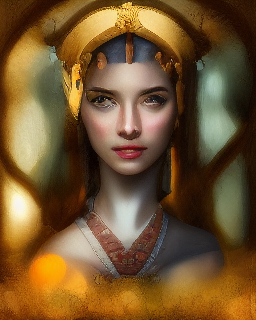

Sampling:   0%|          | 0/1 [00:00<?, ?it/s]

Data shape for DDIM sampling is (1, 4, 40, 32), eta 1.2
Running DDIM Sampling with 100 timesteps


DDIM Sampler:   0%|          | 0/100 [00:00<?, ?it/s]

Data shape for DDIM sampling is (1, 4, 40, 32), eta 1.2
Running DDIM Sampling with 30 timesteps


DDIM Sampler:   0%|          | 0/30 [00:00<?, ?it/s]

In [15]:
# Prompt for clip guidance
prompts = clip_prompts

# Prompt for latent conditioning
opt.prompt = latent_prompts
opt.uc = latent_negatives

#@markdown ### Basic settings 
width = 256 #@param{type: 'integer'}
height = 320 #@param{type: 'integer'}
latent_diffusion_guidance_scale = 1.75 #@param {type:"number"}
clip_guidance_scale = 5000 #@param{type: 'integer'}
how_many_batches = 1 #@param{type: 'integer'}
aesthetic_loss_scale = 500 #@param{type: 'integer'}
opt.n_iter = how_many_batches
opt.n_samples =  1
opt.W, opt.H = [width,height]
opt.scale = latent_diffusion_guidance_scale
augment_cuts=True #@param{type:'boolean'}
aug = augment_cuts
#@markdown ---

#@markdown  ### Init image settings
#@markdown `init_image` requires the path of an image to use as init to the model
init_image = None #@param{type: 'string'}
#@markdown `init_mask` is a mask same width and height as the original image with the color black indicating where to inpaint
init_mask = None #@param{type: 'string'}
#@markdown `init_scale` controls how much the init image should influence the final result. Experiment with values around `1000`
init_scale = 0 #@param{type: 'integer'}
init_brightness = 0.0 #@param{type: 'number'}
#@markdown If you are used to `skip_timesteps` for init images, `init_noise` shares conceptual similarities. Choose the amount of noise to add (0 is no noise, 1 is fully noising it. Experiment with values between 0.3 and 0.7 and check it out)
init_noise = 0 #@param{type: 'integer'}

aes_scale = aesthetic_loss_scale
clip_guidance_index = [clip_guidance_scale]*1000
torch.cuda.empty_cache()
gc.collect()
generate_video = False
if generate_video: 
    fps = 24
    p = Popen(['ffmpeg', '-y', '-f', 'image2pipe', '-vcodec', 'png', '-r', str(fps), '-i', '-', '-vcodec', 'libx264', '-r', str(fps), '-pix_fmt', 'yuv420p', '-crf', '17', '-preset', 'veryslow', 'video.mp4'], stdin=PIPE)
do_run()
if generate_video: 
    p.stdin.close()

### Biases acknowledgment
Despite how impressive being able to turn text into image is, beware to the fact that this model may output content that reinforces or exarcbates societal biases. According to the <a href='https://arxiv.org/abs/2112.10752' target='_blank'>Latent Diffusion paper</a>:<i> \"Deep learning modules tend to reproduce or exacerbate biases that are already present in the data\"</i>. 

The model was trained on an unfiltered version the LAION-400M dataset, which scrapped non-curated image-text-pairs from the internet (the exception being the the removal of illegal content) and is meant to be used for research purposes, such as this one. <a href='https://laion.ai/laion-400-open-dataset/' target='_blank'>You can read more on LAION's website</a>